In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import warnings 
warnings.filterwarnings("ignore")



In [5]:
# Load the df

path = "/home/guts/Documents/accel_data/2024-08-16.csv"
df = pd.read_csv(path)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df

,Timestamp,Linear x,Linear y,Linear z,Filtered x,Filtered y,Filtered z,Angular x,Angular y,Angular z
0,2024-08-16 00:00:00,-0.52,4.12,-0.85,-3.000132,2.681527,-9.357738,0.037655,0.405574,-0.092508
1,2024-08-16 00:00:01,3.14,2.51,-1.31,-1.740184,1.905805,-10.415975,0.034459,0.432205,-0.244840
2,2024-08-16 00:00:02,2.30,3.03,-0.94,-0.168390,2.555233,-7.866748,0.034459,0.468424,-0.515418
3,2024-08-16 00:00:03,6.07,1.82,-1.25,-1.258949,2.762930,-8.702325,0.048308,0.466294,-0.549506
4,2024-08-16 00:00:05,-0.88,4.70,0.25,-1.577977,3.228602,-8.378509,0.051503,0.502513,-0.578268
...,...,...,...,...,...,...,...,...,...,...
2822,2024-08-16 00:48:39,2.30,2.23,2.97,-3.667516,4.598085,-16.605585,0.045112,0.180803,-0.243775
2823,2024-08-16 00:48:40,3.72,2.68,2.08,0.386466,0.128111,-14.369999,0.063221,0.578147,-0.970285
2824,2024-08-16 00:48:41,2.20,6.19,-6.64,1.107719,-1.253344,-1.875857,-0.058219,-0.423202,0.093914
2825,2024-08-16 00:48:42,4.07,6.27,-13.46,-3.989536,0.908022,-14.393342,0.017415,-0.569143,0.949321


In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

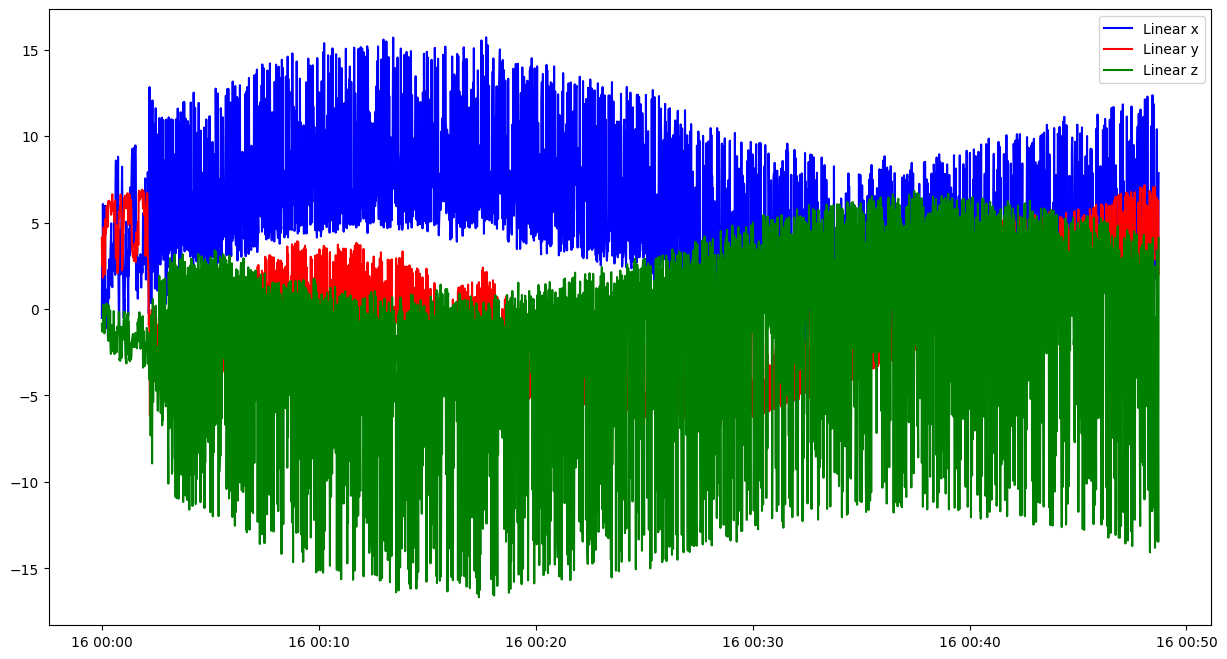

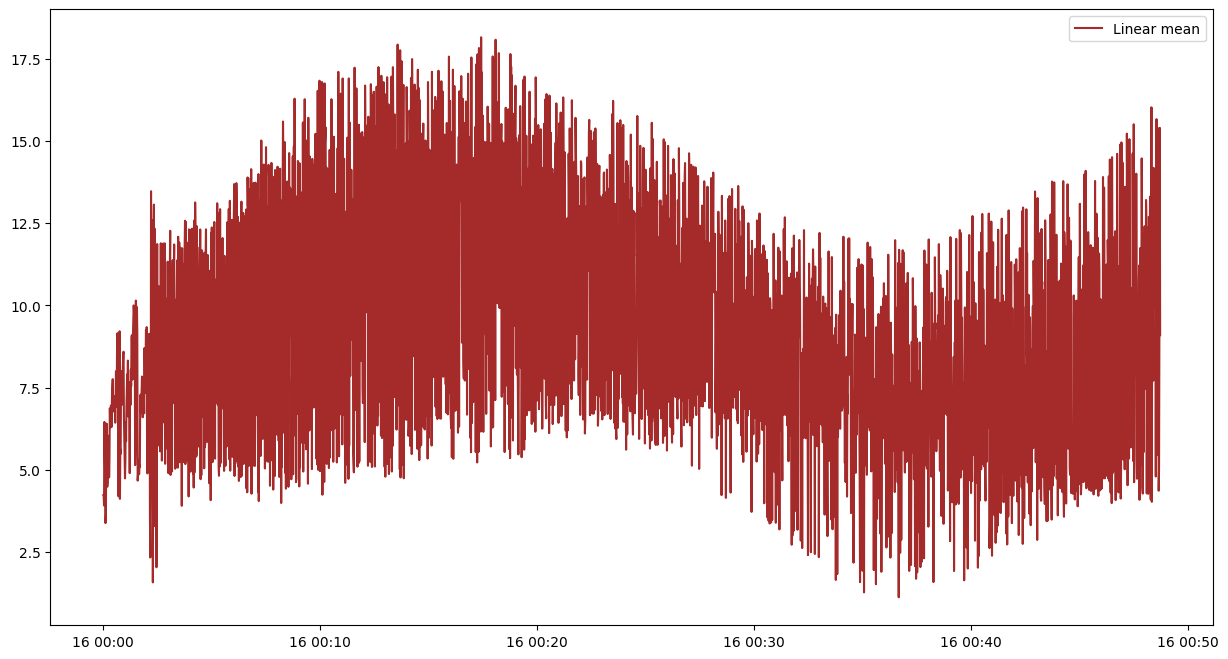

In [7]:
# Plot the df
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Linear x'], label='Linear x', color='blue')
plt.plot(df['Timestamp'],df['Linear y'], label='Linear y', color='red')
plt.plot(df['Timestamp'],df['Linear z'], label='Linear z', color='green')
plt.legend()
plt.show()

df['Linear rms'] = np.sqrt(df['Linear x']**2 + df['Linear y']**2 + df['Linear z']**2)
plt.figure(figsize=(15, 8))
plt.plot(df['Timestamp'],df['Linear rms'], label='Linear mean', color='brown')
plt.legend()
plt.show()

In [8]:
from copy import deepcopy as copy


# Create the dfset with lookback 
def create_dfset(df, n_steps):
    df = copy(df)

    df.set_index('Timestamp', inplace=True)

    for i in range(1, n_steps+1): # Create columns for each lag
        df[f'Acceleration_(t-{i})'] = df['Linear x'].shift(i) # Shift the df by i steps

    df.dropna(inplace=True)
    return df

lookback = 10
shifted_df = create_dfset(df, lookback)
shifted_df

,Linear x,Linear y,Linear z,Filtered x,Filtered y,Filtered z,Angular x,Angular y,Angular z,Linear rms,Acceleration_(t-1),Acceleration_(t-2),Acceleration_(t-3),Acceleration_(t-4),Acceleration_(t-5),Acceleration_(t-6),Acceleration_(t-7),Acceleration_(t-8),Acceleration_(t-9),Acceleration_(t-10)
Timestamp,,,,,,,,,,,,,,,,,,,,
2024-08-16 00:00:12,-0.42,4.62,-0.14,3.819153,0.208915,-12.122441,0.020611,0.160563,-0.640053,4.641164,-1.10,-0.31,5.97,2.50,1.22,-0.88,6.07,2.30,3.14,-0.52
2024-08-16 00:00:13,1.11,5.93,0.32,1.669160,-0.447695,-9.267356,0.024872,0.187195,-0.467481,6.041473,-0.42,-1.10,-0.31,5.97,2.50,1.22,-0.88,6.07,2.30,3.14
2024-08-16 00:00:15,0.48,5.97,-0.00,1.600326,-0.861892,-9.251794,0.012089,0.169085,-0.528201,5.989265,1.11,-0.42,-1.10,-0.31,5.97,2.50,1.22,-0.88,6.07,2.30
2024-08-16 00:00:16,-0.46,4.75,-0.10,1.514135,-1.779469,-10.083779,0.006762,0.144584,-0.461089,4.773269,0.48,1.11,-0.42,-1.10,-0.31,5.97,2.50,1.22,-0.88,6.07
2024-08-16 00:00:17,-1.60,5.09,-0.02,2.720214,-1.142612,-11.058219,-0.002825,0.025274,-0.349236,5.335588,-0.46,0.48,1.11,-0.42,-1.10,-0.31,5.97,2.50,1.22,-0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-16 00:48:39,2.30,2.23,2.97,-3.667516,4.598085,-16.605585,0.045112,0.180803,-0.243775,4.368501,10.39,3.99,1.71,3.91,2.17,1.78,2.95,11.84,1.62,8.79
2024-08-16 00:48:40,3.72,2.68,2.08,0.386466,0.128111,-14.369999,0.063221,0.578147,-0.970285,5.034600,2.30,10.39,3.99,1.71,3.91,2.17,1.78,2.95,11.84,1.62
2024-08-16 00:48:41,2.20,6.19,-6.64,1.107719,-1.253344,-1.875857,-0.058219,-0.423202,0.093914,9.340541,3.72,2.30,10.39,3.99,1.71,3.91,2.17,1.78,2.95,11.84


In [9]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[ -0.42,   4.62,  -0.14, ...,   2.3 ,   3.14,  -0.52],
       [  1.11,   5.93,   0.32, ...,   6.07,   2.3 ,   3.14],
       [  0.48,   5.97,  -0.  , ...,  -0.88,   6.07,   2.3 ],
       ...,
       [  2.2 ,   6.19,  -6.64, ...,   1.78,   2.95,  11.84],
       [  4.07,   6.27, -13.46, ...,   2.17,   1.78,   2.95],
       [  7.86,   2.02,   4.11, ...,   3.91,   2.17,   1.78]])

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the df
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.75135722,  0.64164306,  0.40740741, ..., -0.45602606,
        -0.36482085, -0.76221498],
       [-0.58523344,  0.82719547,  0.44657301, ..., -0.04668838,
        -0.45602606, -0.36482085],
       [-0.65363735,  0.83286119,  0.41932737, ..., -0.80130293,
        -0.04668838, -0.45602606],
       ...,
       [-0.46688382,  0.86402266, -0.14601958, ..., -0.51248643,
        -0.3854506 ,  0.57980456],
       [-0.26384365,  0.87535411, -0.72669221, ..., -0.47014115,
        -0.51248643, -0.3854506 ],
       [ 0.14766558,  0.2733711 ,  0.76926352, ..., -0.28121607,
        -0.47014115, -0.51248643]])

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape   

((2817, 19), (2817,))

In [12]:
X = copy(np.flip(X, axis=1)) # Reverse the order of the columns
X

array([[-0.76221498, -0.36482085, -0.45602606, ...,  0.43903061,
         0.40740741,  0.64164306],
       [-0.36482085, -0.45602606, -0.04668838, ...,  0.25538114,
         0.44657301,  0.82719547],
       [-0.45602606, -0.04668838, -0.80130293, ...,  0.24950149,
         0.41932737,  0.83286119],
       ...,
       [ 0.57980456, -0.3854506 , -0.51248643, ...,  0.20742367,
        -0.14601958,  0.86402266],
       [-0.3854506 , -0.51248643, -0.47014115, ..., -0.2279769 ,
        -0.72669221,  0.87535411],
       [-0.51248643, -0.47014115, -0.28121607, ..., -0.28840946,
         0.76926352,  0.2733711 ]])

In [13]:
split_index = int(0.95 * len(X)) # 95% of the df will be used for training
split_index

2676

In [14]:
# Split the df into training and testing sets

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2676, 19), (2676,), (141, 19), (141,))

In [17]:
# Convert the df to PyTorch tensors
X_train = X_train.reshape(-1, lookback, 1)
X_test = X_test.reshape(-1, lookback, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

ValueError: cannot reshape array of size 50844 into shape (10,1)

In [ ]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
from torch.utils.df import dfset

# Create a custom dfset
class TimeSeriesdfset(dfset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dfset = TimeSeriesdfset(X_train, y_train)
test_dfset = TimeSeriesdfset(X_test, y_test)


In [ ]:
from torch.utils.df import dfLoader
# Create the df loaders

BATCH_SIZE = 16

train_loader = dfLoader(train_dfset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = dfLoader(test_dfset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:


for _, batch in enumerate(train_loader): # Loop through the training df
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(X_batch.shape, y_batch.shape)
    break

In [ ]:
class LSTM(nn.Module): # Define the LSTM model
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(input_size=1, hidden_size=4, num_layers=2).to(device)
model

In [ ]:
def train_one_epoch(): # Train the model for one epoch
    model.train(True)
    print(f'Epoch {epoch+1}')
    train_loss = 0.0

    for i, batch in enumerate(train_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 99: # Print the loss every 100 batches
            avg_loss = train_loss / 100
            print(f'Batch {i}, Loss {loss.item()}')

            train_loss = 0.0

    print()

In [ ]:

def validate_one_epoch(): # Validate the model for one epoch
    model.train(False)
    val_loss = 0.0

    for i, batch in enumerate(test_loader):
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader) # Calculate the average validation loss
    print(f'Validation Loss {avg_val_loss}')
    print()

In [ ]:
# Train the model

learning_rate = 0.001
num_epochs = 10
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

In [ ]:
# Make predictions

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(15, 8))
plt.plot(y_train.cpu().numpy(), label='True')
plt.plot(predicted, label='Predicted')
plt.legend()

In [ ]:
# Inverse transform the df

train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0]= train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = copy(dummies[:,0])
train_predictions

In [ ]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:,0]= y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = copy(dummies[:,0])
new_y_train

In [ ]:
# Plot the predictions

plt.figure(figsize=(15, 8))
plt.plot(new_y_train, label='True')
plt.plot(train_predictions, label='Predicted')
plt.legend()


In [ ]:
# Make predictions on the test set

test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0]= test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = copy(dummies[:,0])
test_predictions

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:,0]= y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = copy(dummies[:,0])
new_y_test

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(new_y_test, label='True')
plt.plot(test_predictions, label='Predicted')
plt.legend()
